# Coupling Polymers to MPCD Solvent

In this session, we will couple a polymer to MPCD solvent. 

## Overview

### Questions

- How do I couple a simple polymer model to MPCD?
- How do hydrodynamic interactions change the diffusion of polymers?
  
### Objectives

- Understand how to couple MD particles to MPCD solvent.
- Set up a simple polymer simulation that now uses MPCD as solvent.


## Boilerplate code

In [8]:
import freud
import gsd.hoomd
import hoomd
import hoomd.azplugins
import hoomd.mpcd
import matplotlib
import numpy 
import fresnel 

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

def render(frame):
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    if frame.bonds.N>0:
        geometry.radius[:] = [0.2]*frame.particles.N 

        all_bonds = numpy.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        # Use a distance cutoff (L/2) to filter bonds that span the periodic boundary
        bond_distances = numpy.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = numpy.where(bond_distances < L/2)[0]
        filtered_bonds = all_bonds[bond_indices, :, :]
        
        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
        bonds.material.primitive_color_mix = 1.0
        bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
        
    return fresnel.preview(scene)


## Background 

We will largely follow [Mussawisade, K., M. Ripoll, R. G. Winkler, and G. Gompper. "Dynamics of polymers in a particle-based mesoscopic solvent." The Journal of chemical physics 123, no. 14 (2005)](http://doi.org/10.1063/1.2041527) for our model/parameter choices. 

## Initialization

While we could simply set up the polymers as rods and make our box very large in the case of a simple non-interacting Gaussian chain with no solvent, this becomes more expensive when using MPCD. The box has to be filled with MPCD particles at the choosen density. For this reason, we have to be a bit more clever about how we initialize the polymer configuration. Often, it might also be desirable to kepp the box size (and/or concentration) fixed, while changing the polymer length. 

For this purpose, we will use a random walk to intialize the polymer positions instead of a straight rod: 

In [9]:
def random_walk(N,origin):
    vec = numpy.random.randn(3, N-1)
    vec /= numpy.linalg.norm(vec, axis=0)
    path = numpy.concatenate([origin.reshape(1,3), vec.T]).cumsum(0)
    return path

In [ ]:
num_pol = 1
num_mon = 80
n = 0 
L = 25

pos_pol = []
while n<num_pol:
    # draw a random walk
    origin = numpy.random.uniform(-L/2., L/2.,3)
    d = random_walk(num_mon,origin)
    # check if monomers are inside of the box 
    if not(numpy.any(d > L/2) or numpy.any(d <-L/2)):
        # if yes, add to position array, if no, keep going in while loop
        pos_pol.append(d)
        n+=1

positions = numpy.asarray(pos_pol).flatten().reshape(-1,3)

bonds = numpy.vstack((numpy.arange(num_pol*num_mon-1),numpy.arange(1,num_pol*num_mon))).T
bonds = bonds[bonds[:,1] % num_mon !=0 ]

frame = gsd.hoomd.Frame()
frame.particles.types = ['monomers']
frame.particles.N = num_mon*num_pol
frame.particles.position = positions
frame.bonds.N = len(bonds)
frame.bonds.group = bonds
frame.bonds.types = ['b']
frame.configuration.box = [L, L, L, 0, 0, 0]

We want to make sure all the MD particles (monomers) have the right mass and no drift in
their velocities. We set the mass of the MD particles to be the same as the mass
of MPCD particles in a collision cell. The collisions cells have unit volume by
default, so this mass is same as the number density, $\rho = 5/\ell^3$, times
the MPCD particle mass *m*. We zero all the velocities of the MD particles, because we will draw the correct velocities for the MPCD particles later. The MPCD particles will then re-thermalize the MD particles very quickly.

In [ ]:
mass = 1
density = 5
kT = 1

frame.particles.mass = [mass * density]*len(positions)
frame.particles.velocity = [0,0,0]*len(positions)

render(frame)

Now we can add the MPCD particles. The `gsd.hoomd.Frame` does not have a field for the MPCD particles. Usually, you do **not** want to write all their positions or properties into gsd files anyway, because that tends to be a lot of data. To circumvent this issue, we will simply read in the MD (monomer) configuration into hoomd-blue, then immediately take a snapshot via `simulation.state.get_snapshot()`. To this `snapshot` object, we can then add the MPCD solvent information. 

Draw random uniform positions and velocities from the correct Maxwell Boltzman distribution for the MPCD particles: 

In [ ]:
box = hoomd.Box.from_box(frame.configuration.box)
rng = numpy.random.default_rng(seed=42)

simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
simulation.create_state_from_snapshot(frame)
snapshot  = simulation.state.get_snapshot()

snapshot.mpcd.types = ["A"]
snapshot.mpcd.N = numpy.round(density * box.volume).astype(int)
snapshot.mpcd.mass = mass
snapshot.mpcd.position[:] = box.L * rng.uniform(
    low=-0.5, high=0.5, size=(snapshot.mpcd.N, 3)
)

vel = rng.normal(loc=0.0, scale=numpy.sqrt(kT / mass), size=(snapshot.mpcd.N, 3))
vel -= numpy.mean(vel, axis=0)
snapshot.mpcd.velocity[:] = vel

simulation.state.set_snapshot(snapshot)


## Configuring the MPCD integrator

Since we have regular HOOMD particles that are embedded in our MPCD particles,
we will need to configure both MD and MPCD options.

### MD configuration

We need to use a timestep that is suitable for MD. Here, we are going use a timestep of $0.01\,\tau$, following the original paper. If a simulation uses stiffer bonds or pair interactions, the timestep needs to be adjusted accordingly!

In [ ]:
integrator = hoomd.mpcd.Integrator(dt=0.01)
simulation.operations.integrator = integrator

Since we want to simulate the same polymer model as before, we only need to define harmonic springs as we did before. We rename the the root-mean-square bond length variable to $b$ (from $l$ used in the original paper), so that it doesn't conflict with the MPCD collison cell size $l$, which is the unit of length. 

In [ ]:
harmonic = hoomd.md.bond.Harmonic()
b = 1 
harmonic.params['b']=dict(k=3*kT/b**2, r0=0.0)

integrator.forces.append(harmonic)

We will use a `ConstantVolume` (NVE) integration method
for the MD particles (monomers). They will be thermostatted through the MPCD particles, so **no** additional/seperate thermostat is needed for the MD particles. 

In [ ]:
nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
integrator.methods.append(nve)

### MPCD configuration

Now that the base MD simulation is configured, we can setup the corresponding
MPCD simulation. The collision method will be our standard SRD fluid
(collision time $\Delta t = 0.1\tau$, collision angle $\alpha = 130^\circ$, and
a thermostat to maintain constant temperature), but **importantly, we now couple
the MD particles (monomers) to the solvent here!**

In [ ]:
integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=numpy.round(0.1 / integrator.dt).astype(int),
    angle=130,
    kT=kT,
    embedded_particles=hoomd.filter.Type(["monomers"])
)

The streaming method will be `Bulk`:

In [ ]:
integrator.streaming_method = hoomd.mpcd.stream.Bulk(
    period=integrator.collision_method.period
)

Last, we make sure we don't forget our sorter for performance.

In [ ]:
integrator.mpcd_particle_sorter = hoomd.mpcd.tune.ParticleSorter(
    trigger=integrator.collision_method.period * 20
)

Now we can run the simulation. Like before, we equilibrate for 100,000 steps and then run for 5 million. We write the results into a gsd file. Don't forget to record the images!

In [ ]:
# Equilibrate 
simulation.run(100_000)

gsd_out = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(1_000), 
    mode='wb',
    dynamic=['property','momentum'],
    filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol))

simulation.operations.writers.append(gsd_out)
# run
simulation.run(5_000_000)

gsd_out.flush()
render(simulation.state.get_snapshot())

## Diffusion Coefficient 

Let's calculate the diffusion coefficient from the simulation. 

In [37]:
def calculate_D(filename,timestep):
    trajectory =  gsd.hoomd.open(filename,'r')
    
    all_unwrapped_positions = []
    all_unwrapped_coms = []
    all_unwrapped_coms_particles = []
    times = []
    
    box  = trajectory[0].configuration.box[0:3]
    bonds =trajectory[0].bonds.group
    polymer_delimiters = bonds[numpy.where((bonds[:-1,1]-bonds[1:,0])!=0)[0]+1][:,0]
    time0 = trajectory[0].configuration.step 
    for frame in trajectory:
    
        unwrapped_positions = frame.particles.position + frame.particles.image*frame.configuration.box[0:3]
    
        unwrapped_positions = unwrapped_positions - numpy.mean(unwrapped_positions,axis=0)
        all_unwrapped_positions.append(unwrapped_positions)
        polymers = numpy.split(unwrapped_positions,polymer_delimiters)
        unwrapped_coms = []
    
        for p in polymers:
            com = numpy.mean(p,axis=0)
            unwrapped_coms.append(com)
    
        unwrapped_coms_tiled = numpy.repeat(unwrapped_coms,len(p),axis=0)
        all_unwrapped_coms_particles.append(unwrapped_positions-unwrapped_coms_tiled)
    
        all_unwrapped_coms.append(unwrapped_coms)
        times.append(frame.configuration.step-time0)
    
    all_unwrapped_positions = numpy.array(all_unwrapped_positions)  # shape = (nframes,numpyarticles,3)
    all_unwrapped_coms = numpy.array(all_unwrapped_coms)            # shape = (nframes,numpyolymers,3)
    all_unwrapped_coms_particles = numpy.array(all_unwrapped_coms_particles)  # shape = (nframes,numpyarticles,3)
    
    msd_calculator = freud.msd.MSD()
    msd_calculator.compute(all_unwrapped_positions)
    result = msd_calculator.particle_msd
    msd1 = numpy.nanmean(result,axis=1)
    
    msd_calculator.compute(all_unwrapped_coms_particles)
    result = msd_calculator.particle_msd
    msd2 = numpy.nanmean(result,axis=1)
    
    msd_calculator.compute(all_unwrapped_coms)
    result = msd_calculator.particle_msd
    msd3 = numpy.nanmean(result,axis=1)
    
    lagtimes = numpy.asarray(times)*timestep

    
    D = numpy.gradient(msd3, lagtimes)/6.0
    av_D = numpy.mean(D[(lagtimes>10) & (lagtimes<30000)])
    return lagtimes, D, av_D, msd3, msd2, msd1

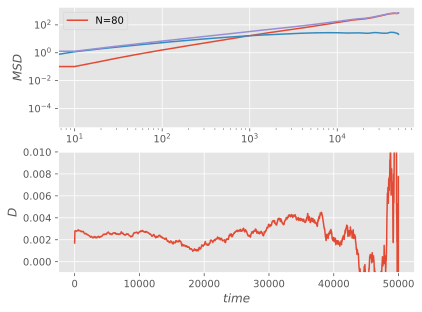

In [38]:
fig,ax = matplotlib.pyplot.subplots(2,1)

N =80
t,D,av_D,MSD,msd2,msd1 = calculate_D('run_len_%s_pol_10.gsd'%N,0.01)
ax[0].plot(t, MSD,label='N=%s'%N)
ax[0].plot(t, msd2)
ax[0].plot(t, msd1)
ax[1].plot(t,D)

ax[0].set_ylabel("$MSD$")
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].set_ylim(-0.001,0.01)

ax[1].set_xlabel(r"$time$")
ax[1].set_ylabel("$D$")

matplotlib.pyplot.show()

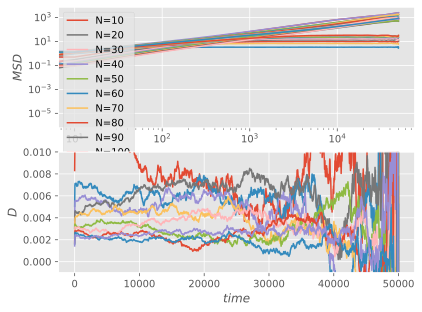

In [39]:
fig,ax = matplotlib.pyplot.subplots(2,1)

for N in [10,20,30,40,50,60,70,80,90,100]:
    t,D,av_D,MSD,msd2,msd1 = calculate_D('run_len_%s_pol_10.gsd'%N,0.01)
    ax[0].plot(t, MSD,label='N=%s'%N)
    ax[0].plot(t, msd2)
    ax[0].plot(t, msd1)
    ax[1].plot(t,D)

ax[0].set_ylabel("$MSD$")
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].set_ylim(-0.001,0.01)

ax[1].set_xlabel(r"$time$")
ax[1].set_ylabel("$D$")

matplotlib.pyplot.show()

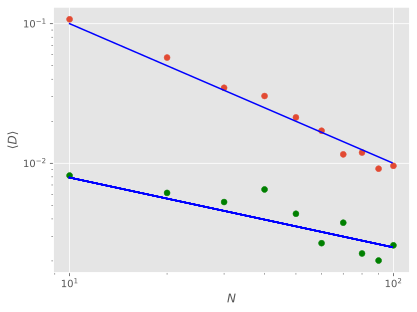

In [46]:
# Results from langevin Gaussian Chain simulation
# See PBC Dynamics Session 8
gaussian = numpy.loadtxt('../8-pbc-dynamics/gaussian-D-Rg.txt')

fig,ax = matplotlib.pyplot.subplots(1,1)
x = numpy.arange(10,100,1)
ax.plot(x,1/x,c='blue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(gaussian[:,0], gaussian[:,1])
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\langle D \rangle$")

all_av_D = []
for N in [10,20,30,40,50,60,70,80,90,100]:
    t,D,av_D,MSD,msd2,msd1 = calculate_D('run_len_%s_pol_10.gsd'%N,0.01)
    ax.scatter(N,av_D,c='green')
    all_av_D.append(av_D)
    ax.plot(x,0.025/x**(1/2),c='blue')

matplotlib.pyplot.show()



In [36]:
num_pol = 10

for num_mon in [10]: 
    L = 25
    
    mass = 1
    density = 5
    kT = 1
    
    pos_pol = []
    n = 0
    while n<num_pol:
        # draw a random walk
        origin = numpy.random.uniform(-L/2., L/2.,3)
        d = random_walk(num_mon,origin)
        # check if monomers are inside of the box 
        if not(numpy.any(d > L/2) or numpy.any(d <-L/2)):
            # if yes, add to position array, if no, keep going in while loop
            pos_pol.append(d)
            n+=1
    
    positions = numpy.asarray(pos_pol).flatten().reshape(-1,3)
    
    bonds = numpy.vstack((numpy.arange(num_pol*num_mon-1),numpy.arange(1,num_pol*num_mon))).T
    bonds = bonds[bonds[:,1] % num_mon !=0 ]
    
    frame = gsd.hoomd.Frame()
    frame.particles.types = ['monomers']
    frame.particles.N = num_mon*num_pol
    frame.particles.position = positions
    frame.bonds.N = len(bonds)
    frame.bonds.group = bonds
    frame.bonds.types = ['b']
    frame.configuration.box = [L, L, L, 0, 0, 0]
  
    frame.particles.mass = [mass * density]*len(positions)
    frame.particles.velocity = [0,0,0]*len(positions)

    box = hoomd.Box.from_box(frame.configuration.box)
    rng = numpy.random.default_rng(seed=42)
    
    simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
    simulation.create_state_from_snapshot(frame)
    snapshot  = simulation.state.get_snapshot()
    
    snapshot.mpcd.types = ["A"]
    snapshot.mpcd.N = numpy.round(density * box.volume).astype(int)
    snapshot.mpcd.mass = mass
    snapshot.mpcd.position[:] = box.L * rng.uniform(
        low=-0.5, high=0.5, size=(snapshot.mpcd.N, 3)
    )
    
    vel = rng.normal(loc=0.0, scale=numpy.sqrt(kT / mass), size=(snapshot.mpcd.N, 3))
    vel -= numpy.mean(vel, axis=0)
    snapshot.mpcd.velocity[:] = vel
    
    simulation.state.set_snapshot(snapshot)

    integrator = hoomd.mpcd.Integrator(dt=0.01)
    simulation.operations.integrator = integrator
    
    harmonic = hoomd.md.bond.Harmonic()
    b = 1 
    harmonic.params['b']=dict(k=3*kT/b**2, r0=0.0)

    integrator.forces.append(harmonic)
    
    nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
    integrator.methods.append(nve)

    integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=numpy.round(0.1 / integrator.dt).astype(int),
    angle=130,
    kT=kT,
    embedded_particles=hoomd.filter.Type(["monomers"])
    )
    
    integrator.streaming_method = hoomd.mpcd.stream.Bulk(
        period=integrator.collision_method.period
    )
    
    integrator.mpcd_particle_sorter = hoomd.mpcd.tune.ParticleSorter(
        trigger=integrator.collision_method.period * 20
    )
    
    simulation.run(100_000)
    
    gsd_out = hoomd.write.GSD(
        trigger=hoomd.trigger.Periodic(1_000), 
        mode='wb',
        dynamic=['property','momentum'],
        filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol))
    
    simulation.operations.writers.append(gsd_out)
    # run
    simulation.run(5_000_000)
    
    gsd_out.flush()



Polymers with hydrodynamic interactions should follow the **Zimm model**, which gives $D \approx \frac{kT}{\eta_s b N^\nu}$, in contrast to $D \approx \frac{kT}{\zeta N}$ for the Rouse model. 

## Radius of Gyration comparison 

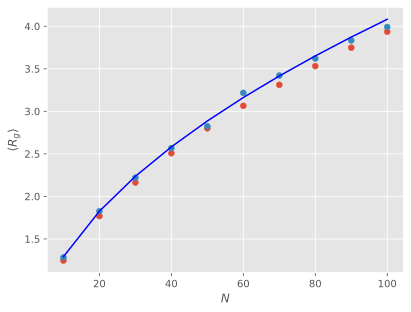

In [45]:
Ns = numpy.array([10,20,30,40,50,60,70,80,90,100])
av_Rg = []
for N in Ns:
    trajectory = gsd.hoomd.open(name='run_len_%s_pol_10.gsd'%N, mode='r')
    rg2 = []
    for frame in trajectory[:-500]:
        unwrapped_positions = frame.particles.position +\
                              frame.particles.image*frame.configuration.box[0:3]
        bonds =frame.bonds.group 
        polymer_delimiters = bonds[numpy.where((bonds[:-1,1]-bonds[1:,0])!=0)[0]+1][:,0]
        polymers  = numpy.split(unwrapped_positions,polymer_delimiters)
        for p in polymers:
            com = numpy.mean(p,axis=0)
            dist_pol_com =  p-com
            Rg2 = numpy.average(numpy.sum(dist_pol_com*dist_pol_com, axis=1))
            rg2.append(Rg2)
    av_Rg.append(numpy.sqrt(numpy.mean(rg2)))

fig, ax = matplotlib.pyplot.subplots()

ax.scatter(gaussian[:,0], gaussian[:,2])
points = ax.scatter(Ns,av_Rg)
line =ax.plot(Ns,(Ns/6)**(1/2),c='blue')
xlabel = ax.set_xlabel(r'$N$')
ylabel = ax.set_ylabel(r'$\langle R_g\rangle$')
matplotlib.pyplot.show()

In [48]:
numpy.savetxt('mpcd-gaussian-D-Rg.txt',numpy.c_[Ns,all_av_D,av_Rg])